# Imports

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from scipy.stats import zscore
import math

# Initial cleaning

In [56]:
costumer = pd.read_csv('customer.csv')

# The Unnamed: 0 column resulted from saving the csv file
costumer.drop('Unnamed: 0', axis=1, inplace=True) 
 
# Replace the null values in the 'is_employed' column with 'False' (empty means no employment)
costumer.fillna({'is_employed': 'False'}, inplace=True)

costumer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   custid          72458 non-null  object 
 1   sex             72458 non-null  object 
 2   is_employed     72458 non-null  object 
 3   income          72458 non-null  float64
 4   marital_status  72458 non-null  object 
 5   health_ins      72458 non-null  bool   
 6   housing_type    70772 non-null  object 
 7   num_vehicles    70772 non-null  float64
 8   age             72458 non-null  int64  
 9   state_of_res    72458 non-null  object 
 10  code_column     72458 non-null  int64  
 11  gas_usage       70772 non-null  float64
 12  rooms           72458 non-null  int64  
 13  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(3), object(7)
memory usage: 7.3+ MB


In [57]:
# Print the columns with missing values
print(' --- PRE CLEANING --- ')
print(' Columns with missing values: ')
print(costumer.isna().sum()) 
old_len = len(costumer)
print('Length of the dataframe: ', old_len)   

# Drop the rest of the rows with missing values
costumer.dropna(axis=0, inplace=True)

print('\n --- POST CLEANING --- ')
print('Length of the dataframe: ', len(costumer)) 
print('Number of rows dropped: ', old_len - len(costumer))


 --- PRE CLEANING --- 
 Columns with missing values: 
custid               0
sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type      1686
num_vehicles      1686
age                  0
state_of_res         0
code_column          0
gas_usage         1686
rooms                0
recent_move_b     1687
dtype: int64
Length of the dataframe:  72458

 --- POST CLEANING --- 
Length of the dataframe:  70771
Number of rows dropped:  1687


In [58]:
# In the dictionary, we are indicated that the values 1, 2, 3 indicate special cases which we decided to separate
costumer['gas_payment'] = costumer['gas_usage'].replace([x for x in costumer['gas_usage'] if x not in [1, 2, 3]], 0)
costumer['gas_bill'] = costumer['gas_usage'].replace([x for x in costumer['gas_usage'] if x in [1, 2, 3]], 0)

# Initial analysis

In [59]:
# We can see all the different scales of the int columns of the data
costumer.describe()

,income,num_vehicles,age,code_column,gas_usage,rooms,gas_payment,gas_bill
count,7.077100e+04,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000,70771.000000
mean,4.263217e+04,2.066849,49.214113,3289.410832,41.231041,3.495146,1.264642,39.966399
std,5.864206e+04,1.170058,17.932735,2663.474061,63.149606,1.706561,1.393938,63.929786
min,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000,0.000000,0.000000
25%,1.130000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000,0.000000,0.000000
50%,2.749000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000,0.000000,10.000000
75%,5.206000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000,3.000000,60.000000
max,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000,3.000000,570.000000


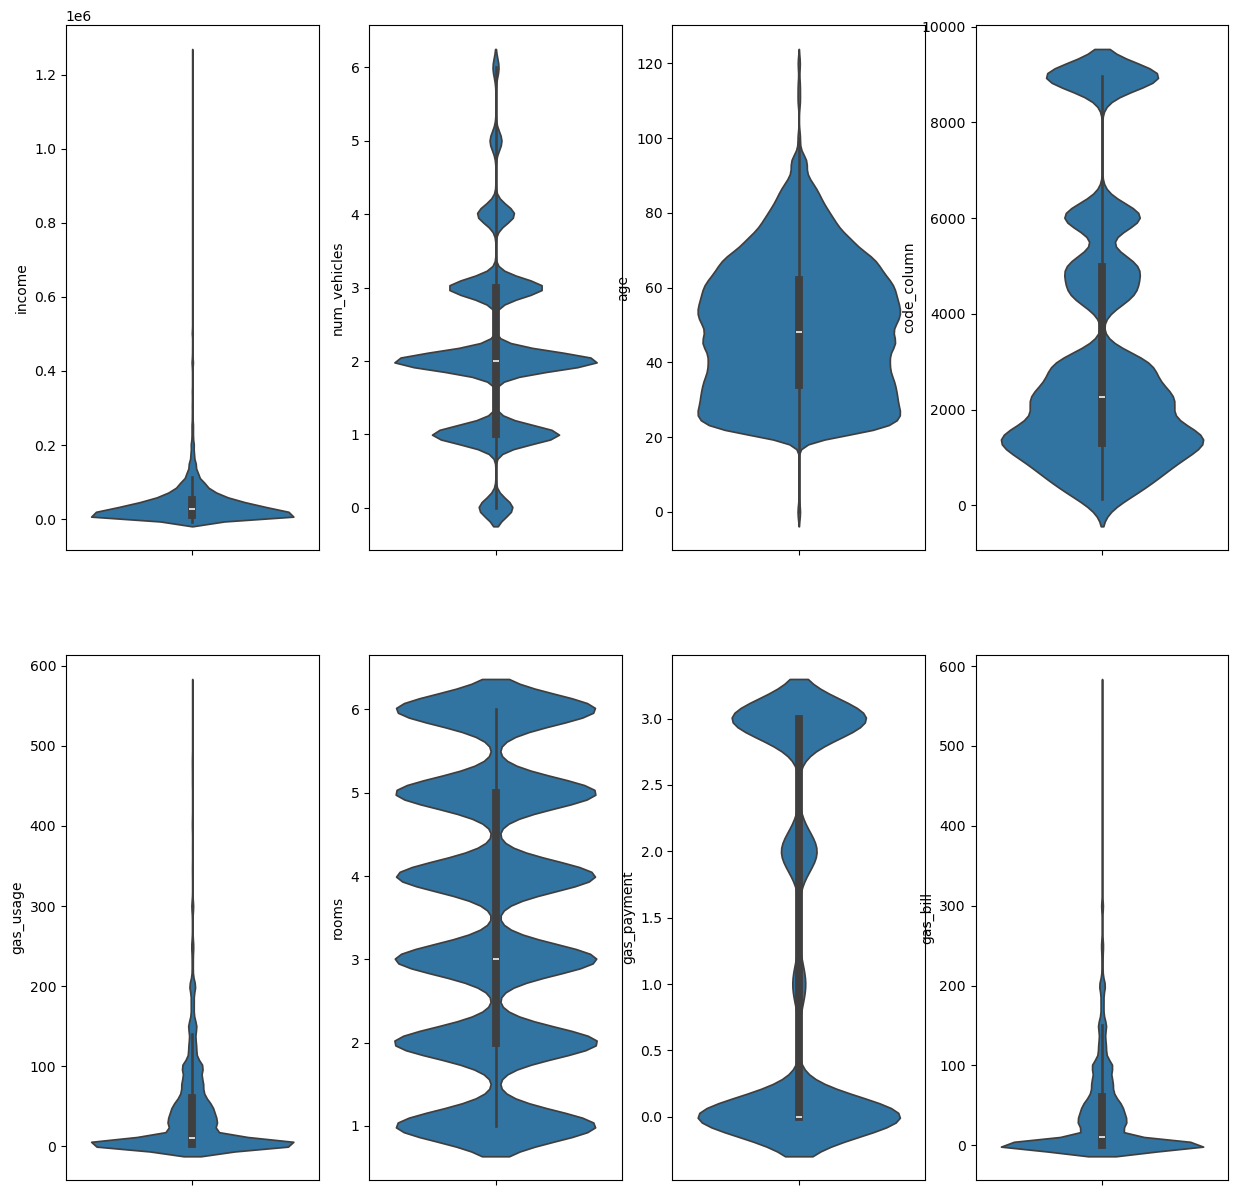

In [60]:
fig, ax = plt.subplots(2,4, figsize=(15,15))

for i, col in enumerate(costumer.select_dtypes(include = ['float64', 'int64']).columns):
    sns.violinplot(data=costumer[col], ax=ax[i//4, i%4])
plt.show()

In [65]:
# Columns chosen to be normalized
cols_norm = ['income', 'gas_usage', 'gas_bill']

c:\Users\castr\anaconda3\envs\IAP2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\castr\anaconda3\envs\IAP2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


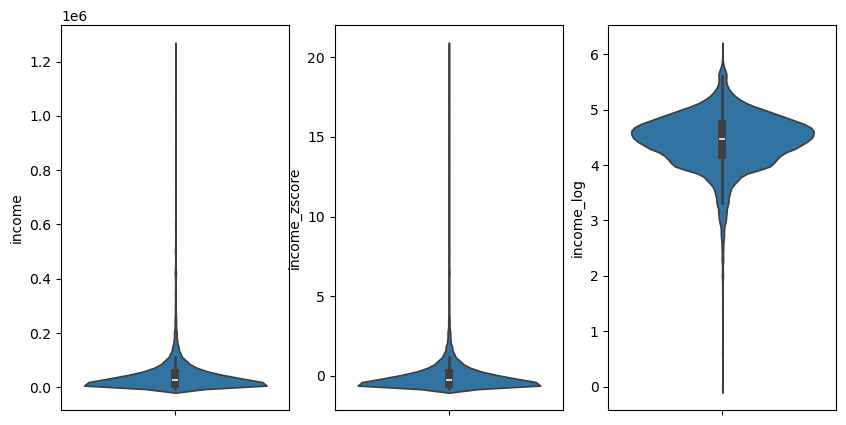

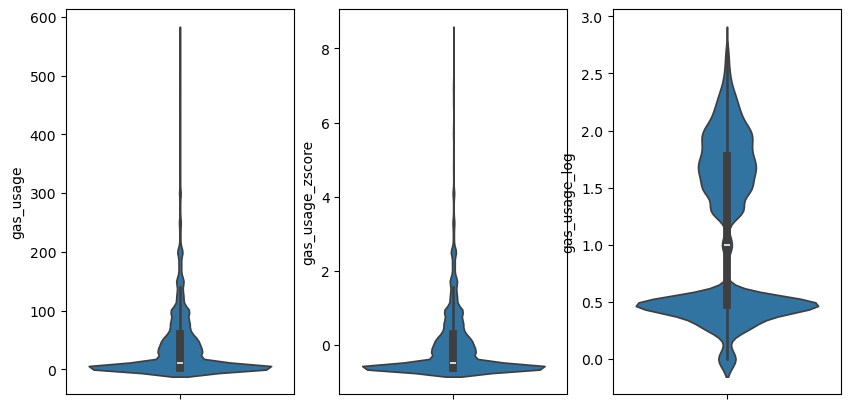

c:\Users\castr\anaconda3\envs\IAP2\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


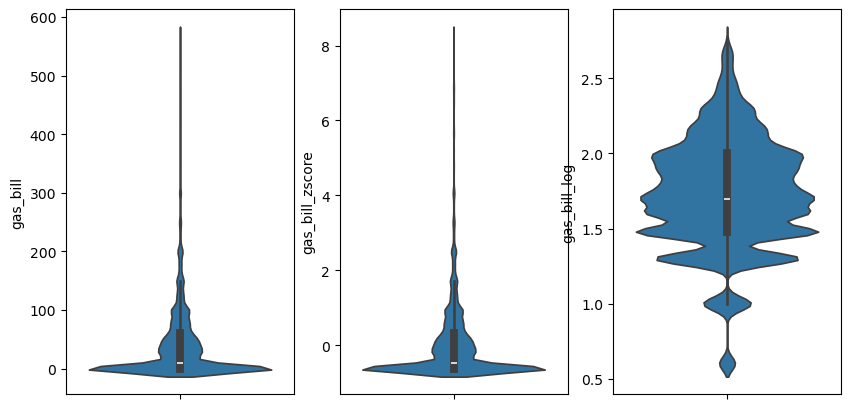

In [69]:
for col in cols_norm:
    costumer[f'{col}_zscore'] = costumer[[col]].apply(zscore)
    costumer[f'{col}_log'] = np.log10(costumer[col], )

    fig, ax = plt.subplots(1,3, figsize=(10,5))
    sns.violinplot(data=costumer[col], ax = ax[0])
    sns.violinplot(data=costumer[f'{col}_zscore'], ax = ax[1])
    sns.violinplot(data=costumer[f'{col}_log'], ax = ax[2])
    plt.show()

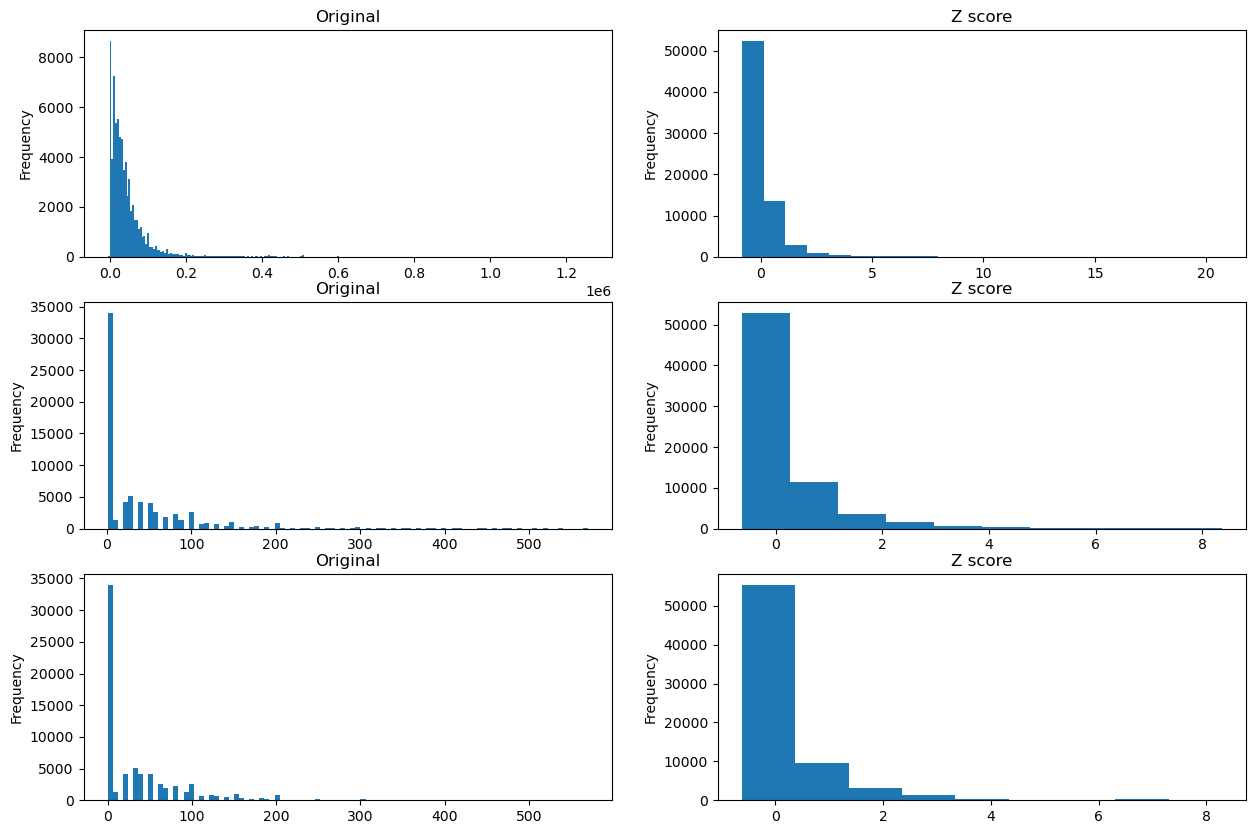

In [100]:
fig, ax = plt.subplots(3,2, figsize=(15,10))

for i, col in enumerate(cols_norm):
    # Use scott's method to determine the number of bins (used in excel and R)
    width = math.ceil(3.5 * (costumer[col].std()) / (math.pow(len(costumer), 1/3)))
    n = math.ceil((costumer[col].max() - costumer[col].min()) / width)
    costumer[col].plot(kind = 'hist', ax = ax[i, 0], bins = n, title='Original')

    width = math.ceil(3.5 * (costumer[f'{col}_zscore'].std()) / (math.pow(len(costumer), 1/3)))
    n = math.ceil((costumer[f'{col}_zscore'].max() - costumer[f'{col}_zscore'].min()) / width)
    costumer[f'{col}_zscore'].plot(kind = 'hist', ax = ax[i, 1], bins = n, title='Z score')
    
plt.show()